In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
import os

os.environ["OMP_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
torch.set_num_threads(8)

batch_size = 32
learning_rate = 0.01
epochs = 30

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)


In [7]:

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x
    
    def get_linear_layers(self) -> list[tuple[str, nn.Module]]:
        return copy.deepcopy([('fc1', self.fc1), ('fc2', self.fc2), ('fc3', self.fc3)])

model = SimpleNN()

In [8]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

model_path = "models/mnist.pth"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model loaded from file.")
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    torch.save(model.state_dict(), model_path)
    print("Model saved.")
    

Model loaded from file.


/tmp/ipykernel_120138/208497290.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [9]:
class FieldLinear(nn.Module):
    def __init__(self, linear, p, f, padding_a, padding_t, gaussian = None):
        super().__init__()
        
        weight = torch.cat([linear.weight, linear.bias.unsqueeze(1)], dim=1)
        
        self.p = p
        self.f = f
        self.weight = self.encode(weight)
        self.orig_weight = copy.deepcopy(self.encode(weight))
        
        self.padding_a = padding_a
        self.padding_t = padding_t
        
        padding = torch.matmul(padding_a, padding_t)
        self.weight = (self.weight + padding) % self.p
            
        if gaussian is not None:
            self.weight = (self.weight + gaussian) % self.p
            self.gaussian = gaussian
        else: 
            self.gaussian = torch.zeros_like(self.weight, dtype=torch.long, device=self.weight.device)

    def encode(self, x):
        x_fixed = torch.round(x * self.f).long()
        return x_fixed % self.p

    def decode_from_field(self, n):
        n = torch.where(n < self.p // 2, n, n - self.p)
        return n

    def decode_from_fixed_point(self, n):
        return n.float() / self.f
    
    
    def precompute(self, x):
        r = padding_tensor(x, self.p) # we only use x for shape
        mr = torch.matmul(r, self.orig_weight.t())
        atr = torch.matmul(r, torch.matmul(self.padding_a, self.padding_t).t() % self.p) 
        gr = torch.matmul(r, self.gaussian.t())
        return r, mr, atr, gr    

    def forward(self, x):
        # Add column of ones for bias
        ones = torch.ones(x.size(0), 1, device=x.device)  # batch_size x 1
        x = torch.cat([x, ones], dim=1)
        
        # CPU: Convert input to fixed-point representation
        x_encoded = self.encode(x)
        x_unpadded = x_encoded.clone()
        
        # CPU: Fetch precomputed values
        r, mr, atr, gr = self.precompute(x_unpadded)
        
        # CPU: Apply padding to x_encoded
        x_encoded = (x_encoded + r) % self.p
        
        # GPU: Performs matrix multiplication
        y_prime = torch.matmul(x_encoded, self.weight.t()) 
        
        # CPU: Reconstruct the output 
        tx = torch.matmul(self.padding_t, x_unpadded.t())
        atx = torch.matmul(self.padding_a, tx).t()
    
        y = (y_prime - atx - mr - atr - gr) % self.p
        y_field = self.decode_from_field(y)
        y_trunc = torch.round(y_field.float() / self.f)
        y = self.decode_from_fixed_point(y_trunc)
        return y
    
'''
m' = (m + p + g)
x' = (x + r)

m'x' = (m + p + g)(x + r) = mx + mr + px + pr + gx + gr
mx = m'x' - mr - px - pr - gr - gx
mx ≈ m'x' - mr - px - pr - gr
'''

accuracy_tests = {}

sigmas = [2, 4, 8, 16, 32, 64, 128, 256]
bits_of_precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


for bits_of_precision in bits_of_precisions:
    for sigma in sigmas:
        p = (1 << 31) - 1
        f = 1 << bits_of_precision

        def padding_tensor(x: torch.Tensor, p: int) -> torch.Tensor:
            return torch.randint(low=0, high=p, size=x.shape, dtype=torch.long, device=x.device)

        def a_t_tensors_like(x: torch.Tensor, p: int, k: int, bias = False) -> tuple[torch.Tensor, torch.Tensor]:
            shape_a = x.shape[0], k
            
            shape_t = k, x.shape[1]
            if bias:
                shape_t = k, (x.shape[1]+1)
            a = torch.randint(low=0, high=p, size=shape_a, dtype=torch.long, device=x.device)
            t = torch.randint(low=0, high=p, size=shape_t, dtype=torch.long, device=x.device)
            return a, t

        def simple_discrete_gaussian_like(tensor: torch.Tensor, sigma: float, p: int):
            # we increase by 1 since we encode the bias as well
            shape = tensor.shape[0], tensor.shape[1]+1
            samples = torch.normal(mean=0, std=sigma, size=shape)
            samples = torch.round(samples).to(torch.int64)
            bound = p // 2
            samples = torch.clamp(samples, min=-bound, max=bound)
            samples = torch.where(samples > 0, samples, samples + p)
            samples = samples % p
            return samples

        linear_layers = model.get_linear_layers()

        for name, layer in linear_layers:
            assert layer.bias is not None, f"Layer {name} does not have a bias."
            
            gaussian = simple_discrete_gaussian_like(layer.weight, sigma=sigma, p=p)
            padding_a, padding_t = a_t_tensors_like(layer.weight, p, k=12, bias=True)
            setattr(model, name, FieldLinear(layer, p=p, f=f, padding_a=padding_a, padding_t=padding_t, gaussian=gaussian))

        print('Field linear')
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                
        accuracy_tests[(bits_of_precision, sigma)] = correct / total 
        print('precision', bits_of_precision, 'sigma', sigma)
        print(f'Accuracy: {correct / total * 100:.2f}%')

        for name, layer in linear_layers:
            setattr(model, name, layer)
            
            # x.shape = (batch_size, w.shape[1])

        print('Real Linear')
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy: {correct / total * 100:.2f}%')

Field linear
precision 2 sigma 2
Accuracy: 12.15%
Real Linear
Accuracy: 96.96%
Field linear
precision 2 sigma 4
Accuracy: 7.41%
Real Linear
Accuracy: 96.96%
Field linear
precision 2 sigma 8
Accuracy: 11.02%
Real Linear
Accuracy: 96.96%
Field linear
precision 2 sigma 16
Accuracy: 10.07%
Real Linear
Accuracy: 96.96%
Field linear
precision 2 sigma 32
Accuracy: 9.18%
Real Linear
Accuracy: 96.96%
Field linear
precision 2 sigma 64
Accuracy: 11.81%
Real Linear
Accuracy: 96.96%
Field linear
precision 2 sigma 128
Accuracy: 8.72%
Real Linear
Accuracy: 96.96%
Field linear
precision 2 sigma 256
Accuracy: 10.02%
Real Linear
Accuracy: 96.96%
Field linear
precision 3 sigma 2
Accuracy: 25.82%
Real Linear
Accuracy: 96.96%
Field linear
precision 3 sigma 4
Accuracy: 4.80%
Real Linear
Accuracy: 96.96%
Field linear
precision 3 sigma 8
Accuracy: 14.05%
Real Linear
Accuracy: 96.96%
Field linear
precision 3 sigma 16
Accuracy: 8.80%
Real Linear
Accuracy: 96.96%
Field linear
precision 3 sigma 32
Accuracy: 11.19

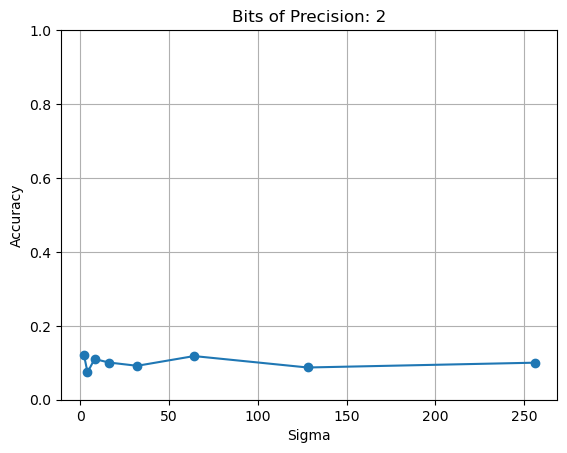

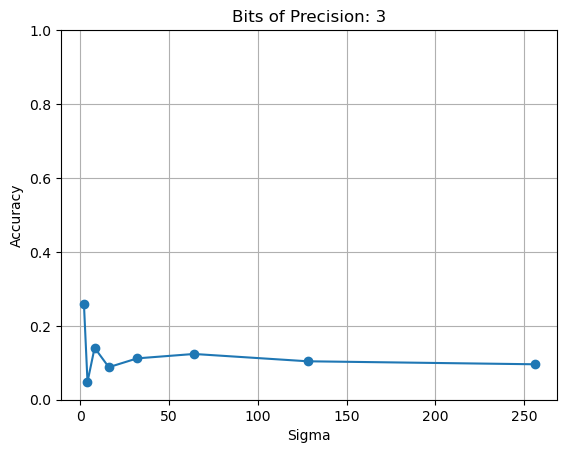

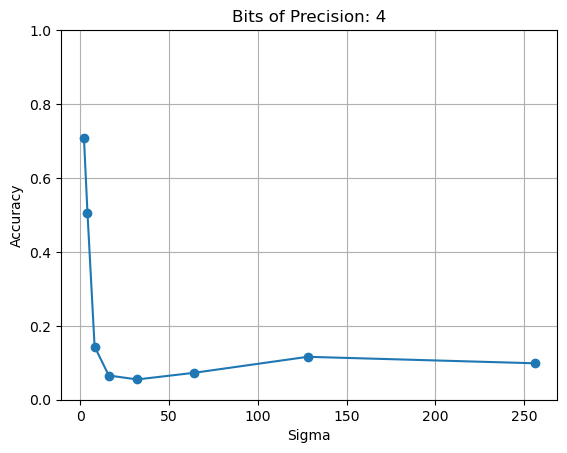

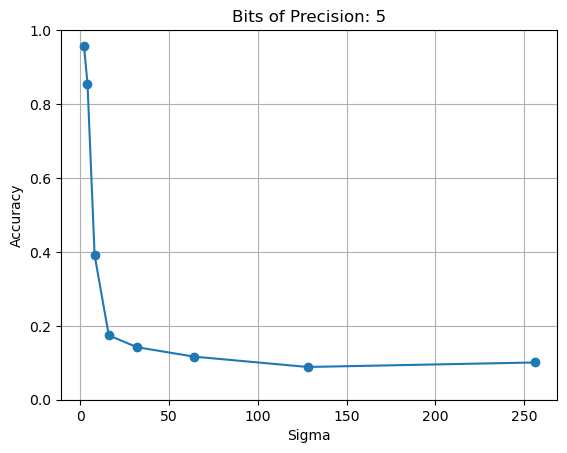

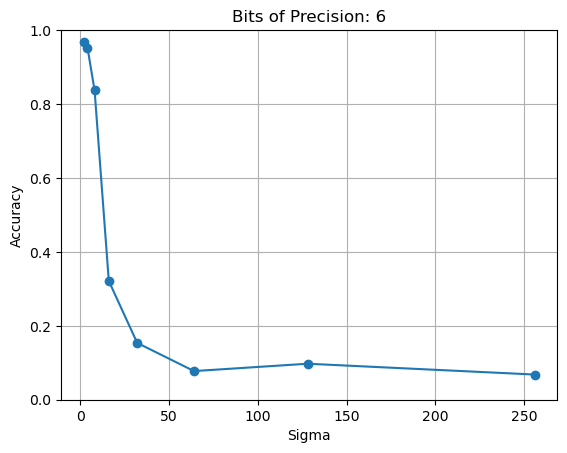

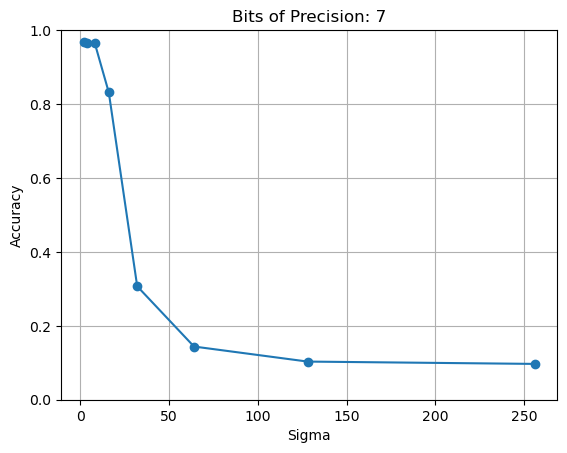

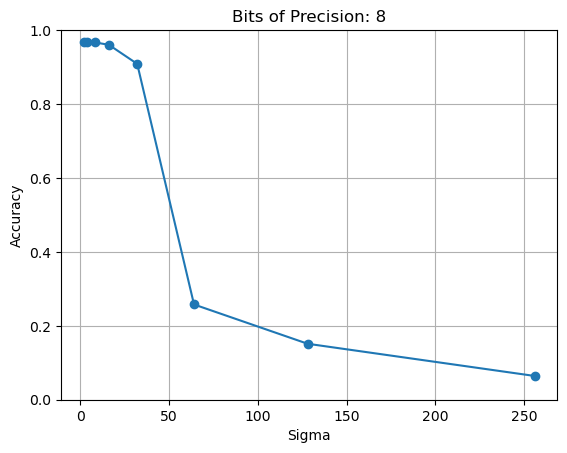

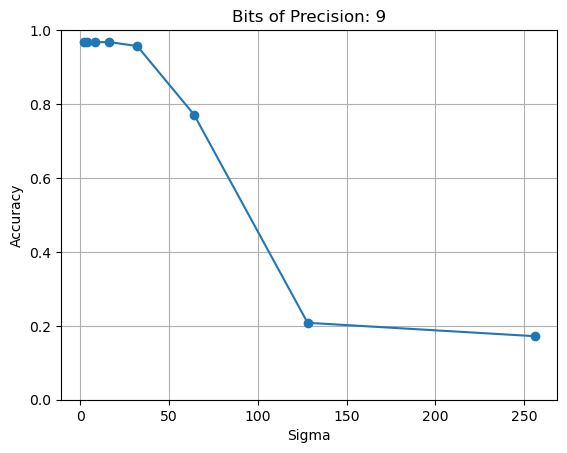

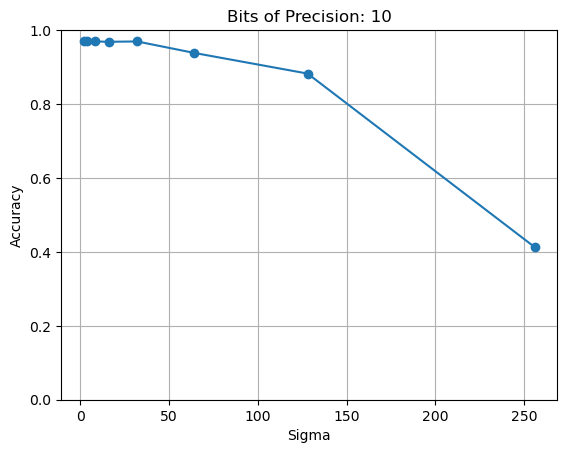

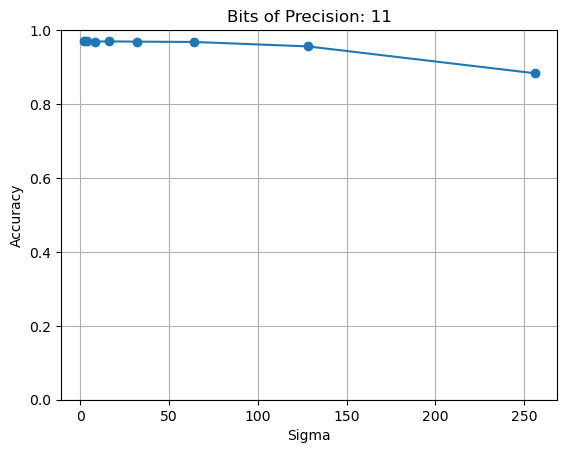

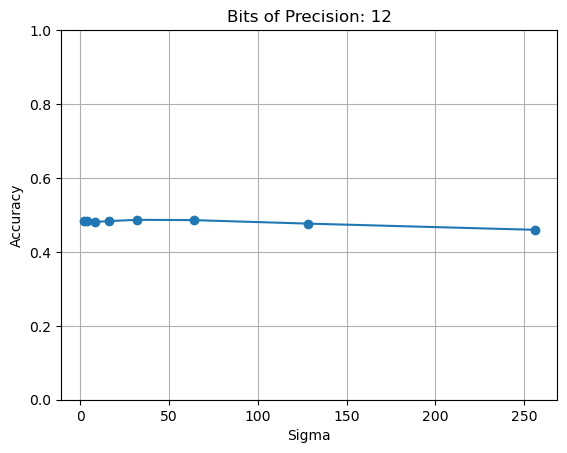

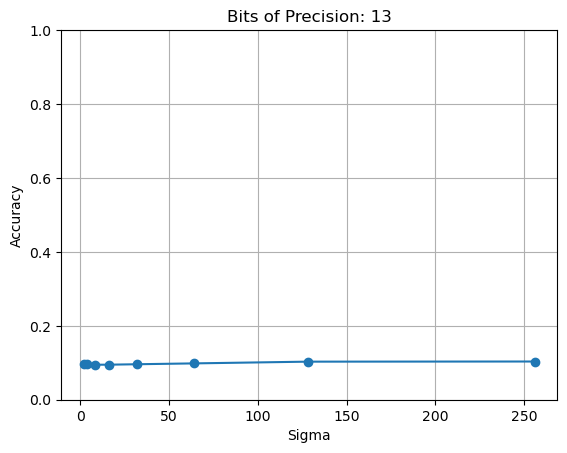

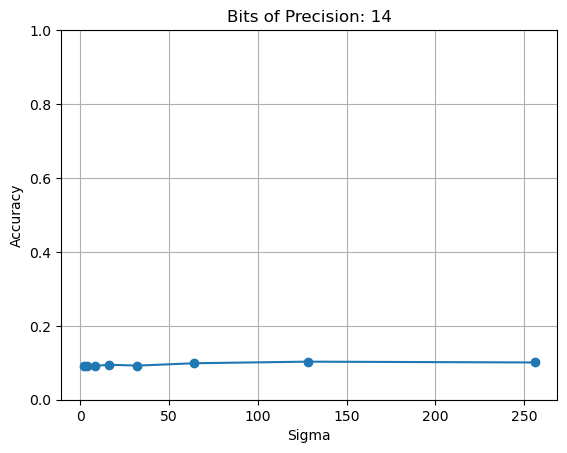

In [12]:
import matplotlib.pyplot as plt

for bits_of_precision in bits_of_precisions:
    accuracies = [accuracy_tests[(bits_of_precision, sigma)] for sigma in sigmas]
    
    plt.figure()
    plt.plot(sigmas, accuracies, marker='o')
    plt.title(f"Bits of Precision: {bits_of_precision}")
    plt.xlabel("Sigma")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)  # accuracies are between 0 and 1
    plt.grid(True)

plt.show()

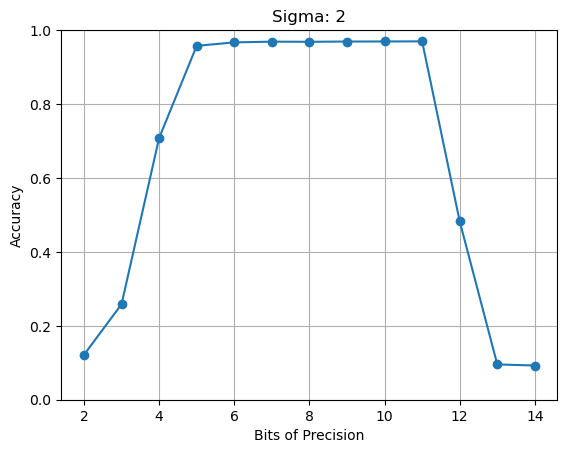

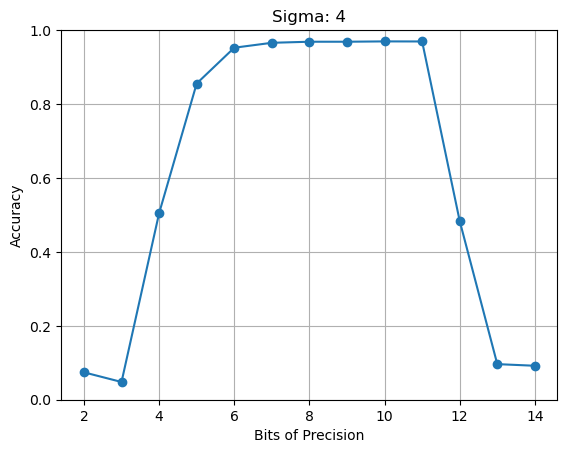

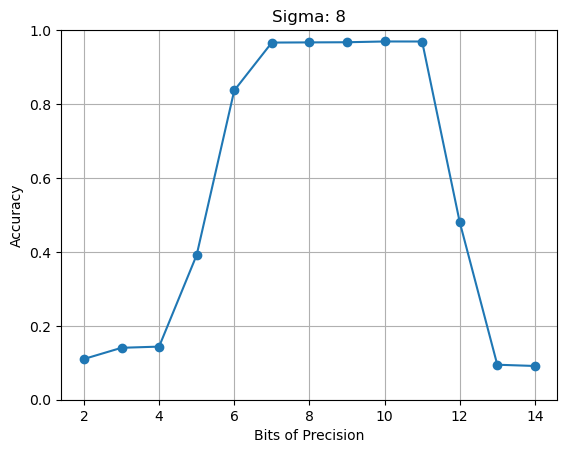

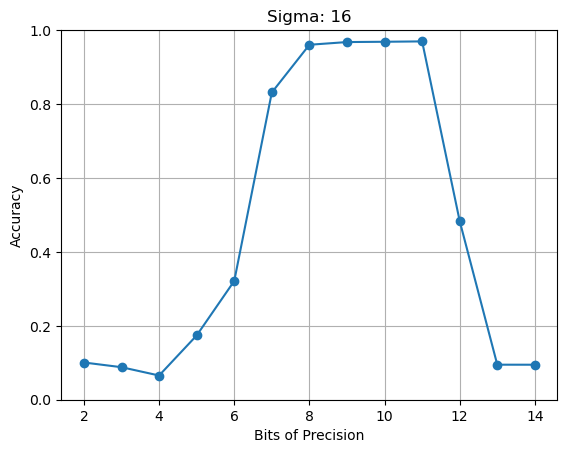

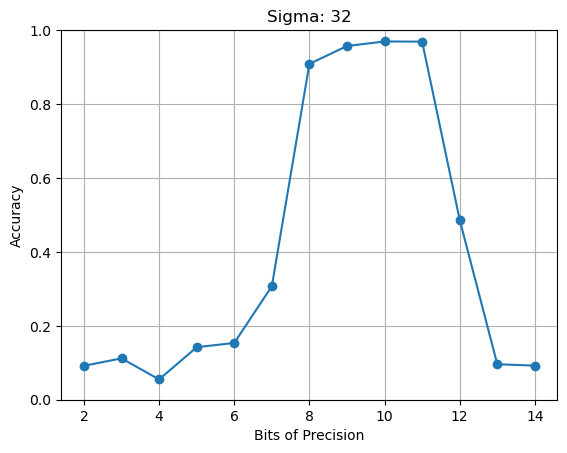

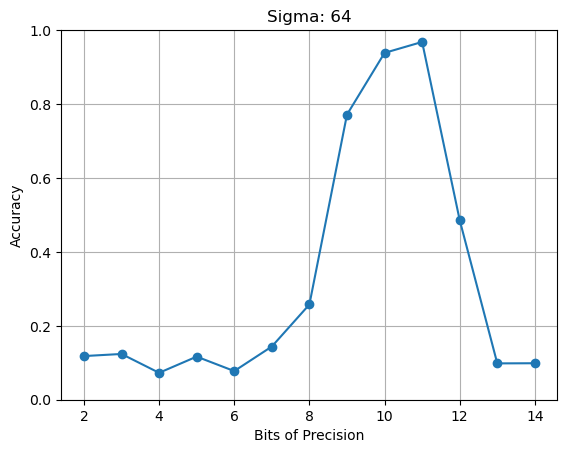

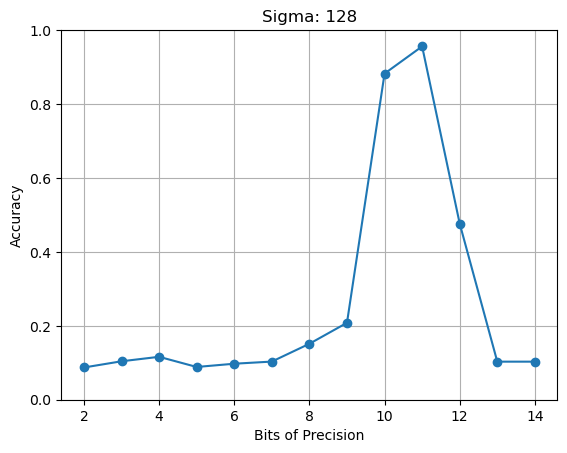

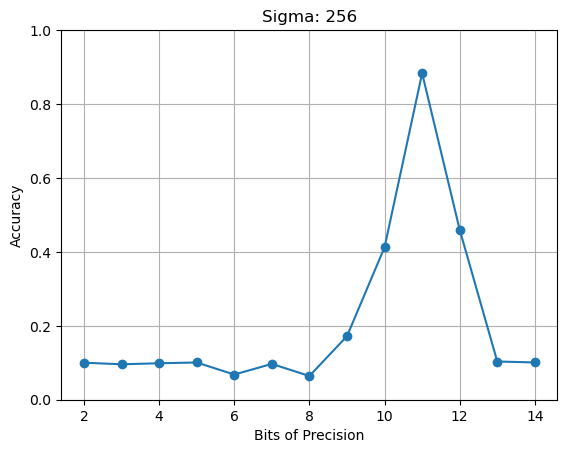

In [13]:
for sigma in sigmas:
    accuracies = [accuracy_tests[(bits, sigma)] for bits in bits_of_precisions]
    
    plt.figure()
    plt.plot(bits_of_precisions, accuracies, marker='o')
    plt.title(f"Sigma: {sigma}")
    plt.xlabel("Bits of Precision")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(True)

plt.show()

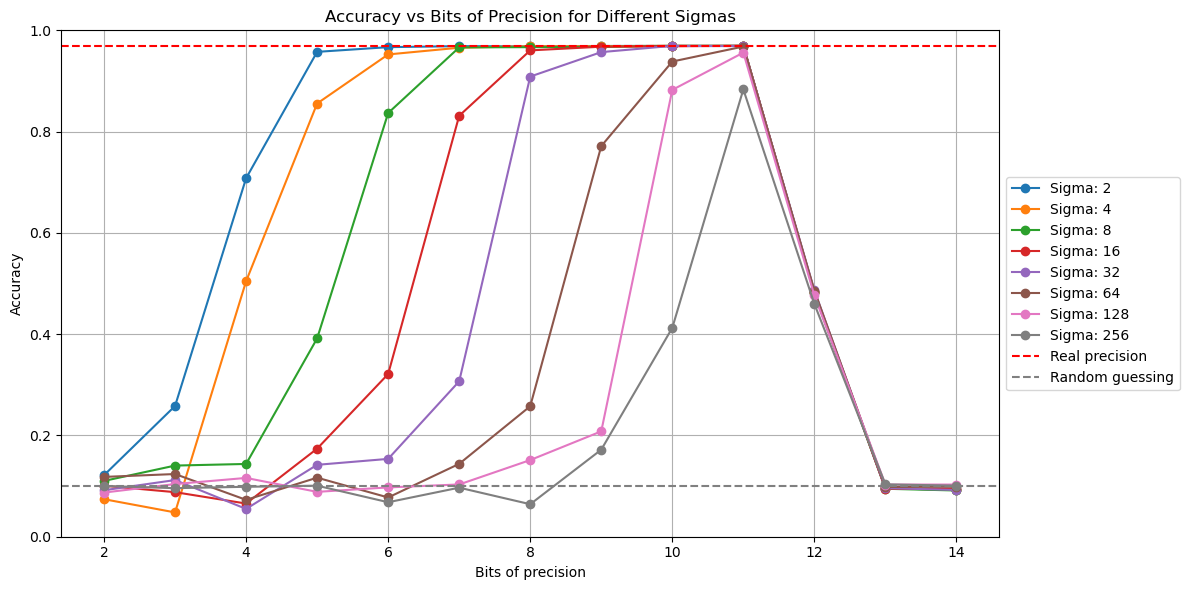

In [20]:
plt.figure(figsize=(12, 6))
for sigma in sigmas:
    accuracies = [accuracy_tests[(bits, sigma)] for bits in bits_of_precisions]
    plt.plot(bits_of_precisions, accuracies, marker='o', label=f"Sigma: {sigma}")
    
real_precision = 0.9696
plt.axhline(y=real_precision, color='red', linestyle='--', label="Real precision")

random_guessing = 0.1
plt.axhline(y=random_guessing, color='grey', linestyle='--', label="Random guessing")


plt.xlabel("Bits of precision")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Accuracy vs Bits of Precision for Different Sigmas")
plt.grid(True)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()